In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1274.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1271.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1283.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1204.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1200.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1310.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1299.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1202.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1276.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1225.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1217.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os


In [5]:
train_dir = "/kaggle/input/brain-tumor-mris/brain_tumor_mris/Training"
val_dir = "/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation"
test_dir = "/kaggle/input/brain-tumor-mris/brain_tumor_mris/Testing"


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [7]:
# Get the class names (folder names)
class_names = sorted(os.listdir(train_dir))
print("Classes:", class_names)

# Dictionary to store one image path from each class
image_paths = {class_name: os.path.join(train_dir, class_name, os.listdir(os.path.join(train_dir, class_name))[0])
               for class_name in class_names}


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


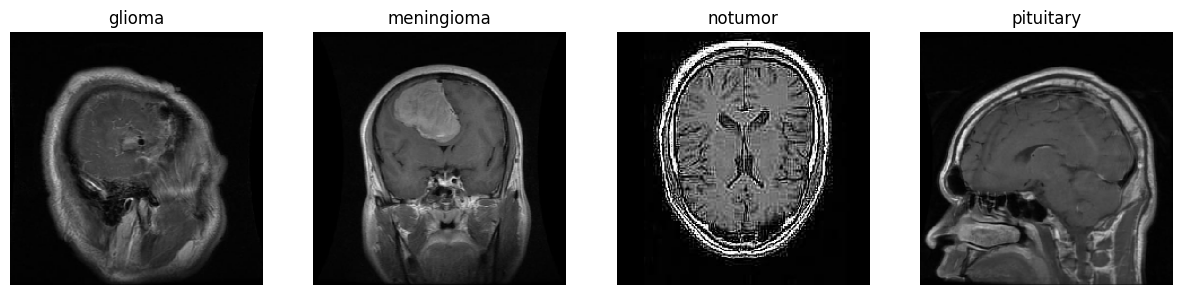

In [9]:
fig, axes = plt.subplots(1, len(class_names), figsize=(15, 5))

for ax, (class_name, image_path) in zip(axes, image_paths.items()):
    img = load_img(image_path, target_size=(224, 224))  # Load image
    ax.imshow(img)
    ax.set_title(class_name)
    ax.axis("off")  # Hide axis

plt.show()


**Data Augmentation**

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

In [11]:
img_height = 224
img_width = 224
batch_size = 32

In [12]:
img_size = (img_height, img_width)

In [13]:
import keras
data_augmentation = keras.Sequential(
[
    layers.RandomFlip("horizontal",
                     input_shape=(img_height,
                                 img_width,
                                  3)),

    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 4672 images belonging to 4 classes.


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


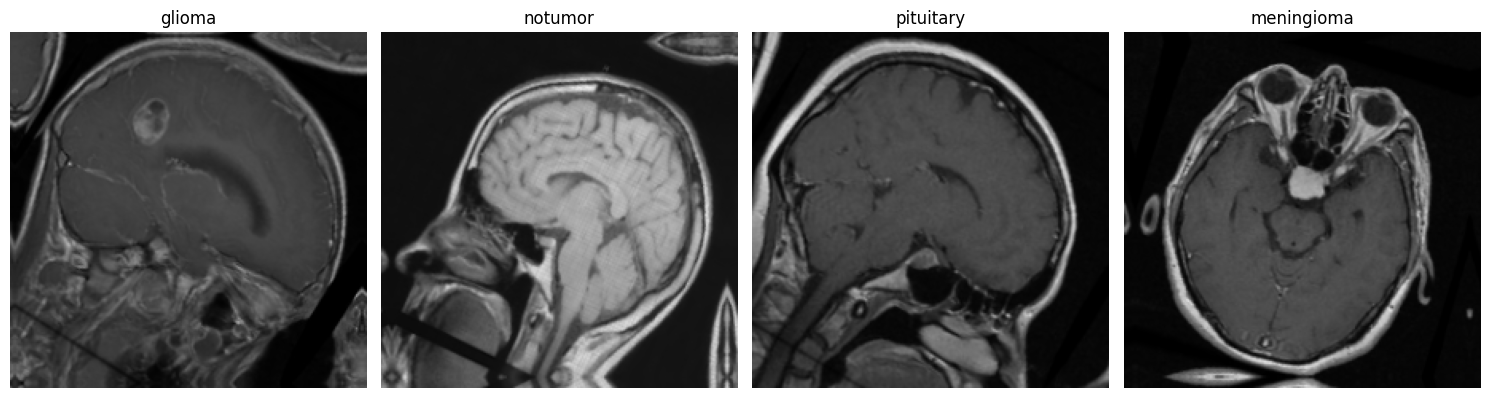

In [15]:
# Get class names
class_names = list(train_generator.class_indices.keys())
print("Classes:", class_names)

# Initialize plot
fig, axes = plt.subplots(1, len(class_names), figsize=(15, 5))

# Dictionary to store one augmented image per class
displayed_classes = set()

# Iterate through the dataset to find one image per class
for images, labels in train_generator:
    for i in range(len(labels)):
        class_index = np.argmax(labels[i])  # Get class index
        class_name = class_names[class_index]

        if class_name not in displayed_classes:
            # Apply augmentation
            augmented_img = data_augmentation(tf.expand_dims(images[i], axis=0))

            # Display image
            axes[len(displayed_classes)].imshow(augmented_img[0])
            axes[len(displayed_classes)].set_title(class_name)
            axes[len(displayed_classes)].axis("off")

            displayed_classes.add(class_name)

        if len(displayed_classes) == len(class_names):  # Stop when all classes are covered
            break
    if len(displayed_classes) == len(class_names):
        break

plt.tight_layout()
plt.show()


In [16]:
# Validation & Testing data generators (No augmentation, only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)

Found 4672 images belonging to 4 classes.
Found 576 images belonging to 4 classes.
Found 576 images belonging to 4 classes.


In [17]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Number of output classes
num_classes = len(class_names)

# Load the InceptionV3 model without the top layers
base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Freeze the base model to retain pre-trained weights
base_model.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling to reduce dimensions
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Softmax for multi-class classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 23,905,060 (91.19 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [22]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Stop if validation loss doesn't improve
    patience=20,         # Wait for 10 epochs before stopping
    restore_best_weights=True  # Restore the best model weights
)

# Train the model
history = model.fit(
    train_generator,
    epochs=200,  # Train for 100 epochs
    validation_data=val_generator,  # Use validation set for monitoring
    callbacks=[early_stopping]  # Apply early stopping
)


Epoch 1/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 19s 128ms/step - accuracy: 0.8188 - loss: 0.4777 - val_accuracy: 0.8003 - val_loss: 0.5932
Epoch 2/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - accuracy: 0.8138 - loss: 0.5244 - val_accuracy: 0.7812 - val_loss: 0.5438
Epoch 3/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 0.8271 - loss: 0.4815 - val_accuracy: 0.7656 - val_loss: 0.5640
Epoch 4/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 16s 107ms/step - accuracy: 0.8460 - loss: 0.4205 - val_accuracy: 0.7969 - val_loss: 0.6220
Epoch 5/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 24s 153ms/step - accuracy: 0.8370 - loss: 0.4360 - val_accuracy: 0.7934 - val_loss: 0.5074
Epoch 6/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 17s 109ms/step - accuracy: 0.8531 - loss: 0.3996 - val_accuracy: 0.7830 - val_loss: 0.5769
Epoch 7/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - accuracy: 0.8388 - loss: 0.4238 - val_accuracy: 0.8003 - val_loss: 0.5064
Epoch 8/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.8440 - los

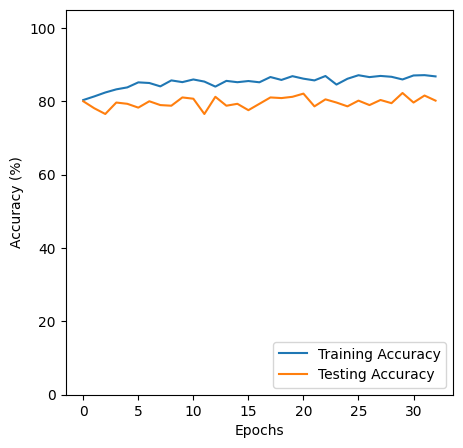

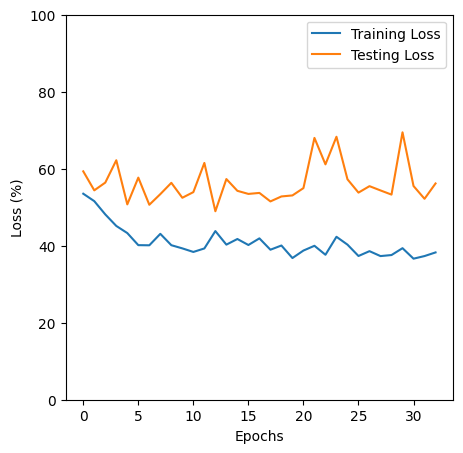

In [23]:
import matplotlib.pyplot as plt

# Extract training and validation metrics
acc = [a * 100 for a in history.history['accuracy']]
val_acc = [a * 100 for a in history.history['val_accuracy']]
loss = [b * 100 for b in history.history['loss']]
val_loss = [b * 100 for b in history.history['val_loss']]
epochs_range = range(len(acc))

# Plot Training & Validation Accuracy
plt.figure(figsize=(5, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
#plt.title("Training & Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 105])  # Ensure values stay within range
#plt.grid(True, linestyle='--', alpha=0.5)  # Add grid lines for better visualization
plt.savefig('InceptionV3_200_training_validation_accuracy.png')
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(5, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Testing Loss')
plt.legend(loc='upper right')
#plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (%)')
plt.ylim([0, 100])
#plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('InceptionV3_200_training_validation_loss.png')
plt.show()


In [24]:
model.evaluate(train_generator) # Training accuracy and loss

146/146 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.9667 - loss: 0.1868


[0.18662475049495697, 0.9681078791618347]

In [25]:
model.evaluate(val_generator) # Validation accuracy and loss

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.7970 - loss: 0.5392


[0.4895384609699249, 0.8125]

In [26]:
model.evaluate(test_generator) # Testing accuracy and loss

18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 267ms/step - accuracy: 0.9108 - loss: 0.2980


[0.2950139045715332, 0.9201388955116272]

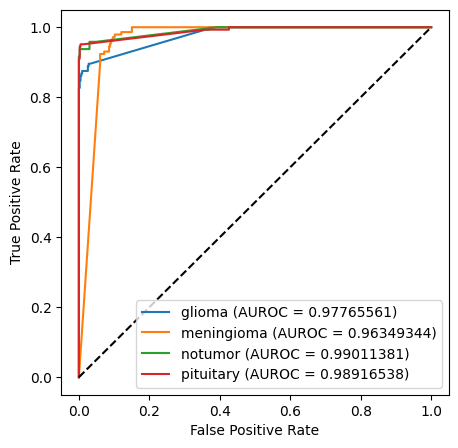

In [28]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Get true labels and one-hot encode them
y_true = test_generator.classes  # True labels from test set
y_true_binarized = label_binarize(y_true, classes=np.arange(num_classes))

# Predict probabilities in one step (faster execution)
y_pred_probs = model.predict(test_generator, verbose=0)

# Create figure for ROC curves
plt.figure(figsize=(5, 5))

# Compute and plot ROC curve for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUROC = {roc_auc:.8f})')

# Formatting
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
#plt.grid(True, linestyle='--', alpha=0.6)

# Save and display the AUROC plot
plt.savefig('InceptionV3_AUROC.png', dpi=300, bbox_inches='tight')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


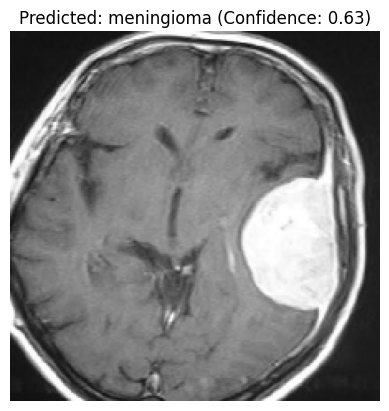

In [29]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os

# Select an image from the testing set
test_image_path = "/kaggle/input/brain-tumor-mris/brain_tumor_mris/Testing/meningioma/Te-me_0012.jpg"  # Change this to any test image path

# Load and preprocess the image
img = image.load_img(test_image_path, target_size=(224, 224))  # Resize to ResNet50 input size
img_array = image.img_to_array(img)  # Convert to NumPy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize (if preprocessing requires)

# Make prediction
pred_probs = model.predict(img_array)
pred_class = np.argmax(pred_probs, axis=1)[0]  # Get the class index

# Get class label
pred_class_name = class_names[pred_class]  # Assuming class_names contains the actual labels

# Display image with prediction
plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted: {pred_class_name} (Confidence: {pred_probs[0][pred_class]:.2f})")
plt.show()


In [30]:
from sklearn.metrics import classification_report, confusion_matrix

# y_true is already in label format, so don't apply argmax
y_true_classes = y_true  # No need for np.argmax
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Generate classification report and confusion matrix
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))
print(confusion_matrix(y_true_classes, y_pred_classes))


              precision    recall  f1-score   support

      glioma       0.95      0.88      0.91       144
  meningioma       0.78      0.96      0.86       144
     notumor       0.99      0.94      0.96       144
   pituitary       1.00      0.91      0.95       144

    accuracy                           0.92       576
   macro avg       0.93      0.92      0.92       576
weighted avg       0.93      0.92      0.92       576

[[126  18   0   0]
 [  5 138   1   0]
 [  0   9 135   0]
 [  1  12   0 131]]


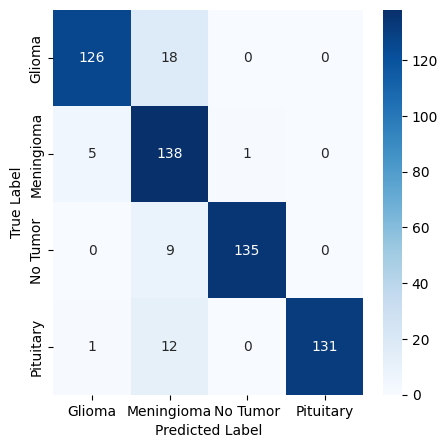

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, np.argmax(y_pred_probs, axis=1))

# Define class names (Modify as per your dataset)
class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Formatting
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
#plt.title('Confusion Matrix')

# Save the confusion matrix as an image
plt.savefig('InceptionV3_200_confusion_matrix.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [32]:
# Save the entire model (architecture + weights + optimizer state)
model.save('InceptionV3_model.h5')


In [33]:
# Save the model in the new .keras format
model.save('InceptionV3_model.keras')


In [34]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('InceptionV3_model.keras')


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


**Explainable AI**

In [35]:
IMG_SIZE = (224, 224)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━

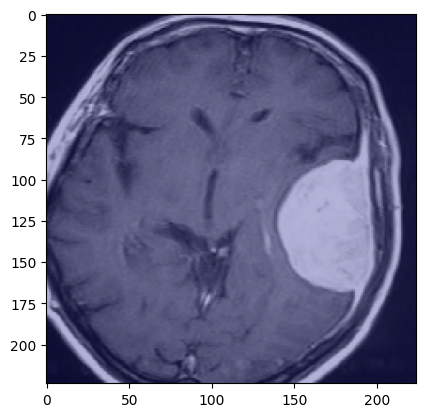

In [37]:
def occlusion_sensitivity(img_path, model, patch_size=20):
    img = keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    occlusion_map = np.zeros_like(img_array[0, :, :, 0])

    for i in range(0, IMG_SIZE[0], patch_size):
        for j in range(0, IMG_SIZE[1], patch_size):
            occluded_img = img_array.copy()
            occluded_img[0, i:i+patch_size, j:j+patch_size, :] = 0

            prediction = model.predict(occluded_img)
            class_idx = np.argmax(prediction[0])

            occlusion_map[i:i+patch_size, j:j+patch_size] = prediction[0][class_idx]

    plt.imshow(img)
    plt.imshow(occlusion_map, cmap='jet', alpha=0.3)
    plt.show()

# Run Occlusion Sensitivity
occlusion_sensitivity("/kaggle/input/brain-tumor-mris/brain_tumor_mris/Testing/meningioma/Te-me_0012.jpg", model)


In [14]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=29b451e2ff7b4deb5c89eac2f41e390a0478cdc7fc84f01a4d4999117fc51817
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━

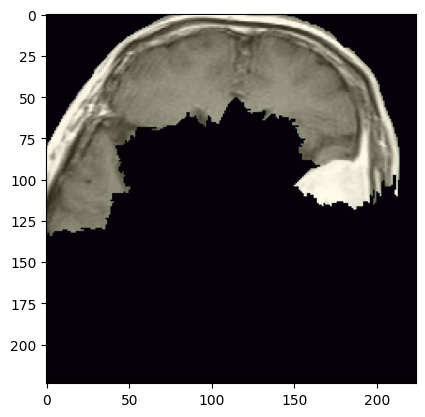

In [38]:
from lime import lime_image

def explain_lime(img_path, model):
    img = keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = keras.preprocessing.image.img_to_array(img) / 255.0

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        img_array.astype('double'),
        model.predict,
        top_labels=5,
        hide_color=0,
        num_samples=1000
    )

    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True
    )

    plt.imshow(temp)
    plt.imshow(mask, alpha=0.1)
    plt.show()

explain_lime("/kaggle/input/brain-tumor-mris/brain_tumor_mris/Testing/meningioma/Te-me_0012.jpg", model)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

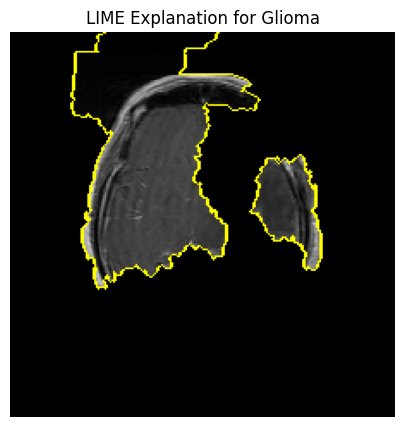

In [39]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from lime.lime_image import LimeImageExplainer  # Correct Import
from skimage.segmentation import mark_boundaries

def explain_lime(img_path, model, class_names):
    # Load and preprocess the image
    img = keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Initialize the LIME Explainer
    explainer = LimeImageExplainer()

    # Explain the model's prediction
    explanation = explainer.explain_instance(
        img_array[0].astype('double'),
        model.predict,
        top_labels=5,
        hide_color=0,
        num_samples=1000
    )

    # Get LIME mask and overlay on image
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True
    )

    # Display the explanation
    plt.figure(figsize=(5, 5))
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f"LIME Explanation for {class_names[explanation.top_labels[0]]}")
    plt.axis("off")
    plt.show()

# Run LIME
explain_lime("/kaggle/input/brain-tumor-mris/brain_tumor_mris/Testing/glioma/Te-gl_0022.jpg", model, class_names)


<ipython-input-41-c1de88fe5b55>:33: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)  # Normalize
<ipython-input-41-c1de88fe5b55>:37: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


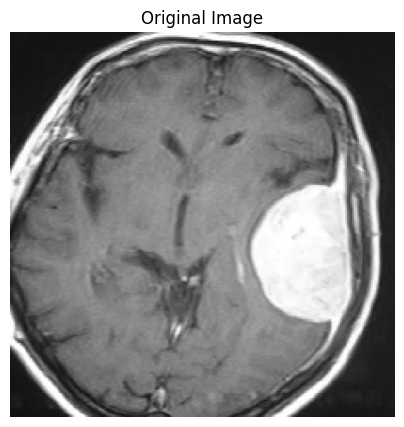

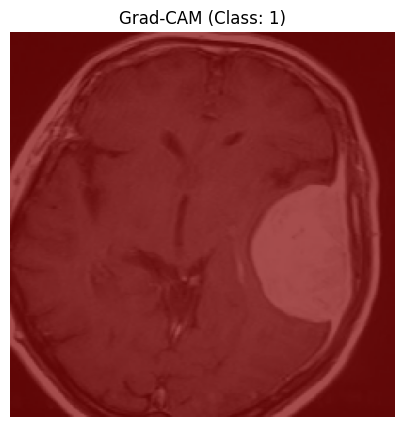

In [41]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras

# Define Grad-CAM function
def grad_cam(img_path, model, layer_name, img_size=(224, 224), alpha=0.3):
    # Load and preprocess image
    img = keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img_array = keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Get last convolutional layer and model output
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        class_idx = np.argmax(predictions[0])  # Get predicted class
        loss = predictions[:, class_idx]

    # Compute gradients
    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Global average pooling

    # Compute heatmap
    conv_output = conv_output[0]
    heatmap = np.dot(conv_output, pooled_grads.numpy())
    heatmap = np.maximum(heatmap, 0)  # Apply ReLU
    heatmap /= np.max(heatmap)  # Normalize

    # Resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (img_size[1], img_size[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay heatmap on original image
    superimposed_img = cv2.addWeighted(np.array(img), alpha, heatmap, 1 - alpha, 0)

    # Show original image and Grad-CAM
    plt.figure(figsize=(5, 5))
    #plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")

    plt.figure(figsize=(5, 5))
    #plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM (Class: {class_idx})")
    plt.axis("off")

    plt.show()

# Run Grad-CAM
grad_cam(
    img_path="/kaggle/input/brain-tumor-mris/brain_tumor_mris/Testing/meningioma/Te-me_0012.jpg",
    model=model,
    layer_name="conv2d_93"
)


In [40]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 26,007,338 (99.21 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 2,102,278 (8.02 MB)

<ipython-input-42-aefeda2c8e1e>:42: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)  # Normalize
<ipython-input-42-aefeda2c8e1e>:46: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


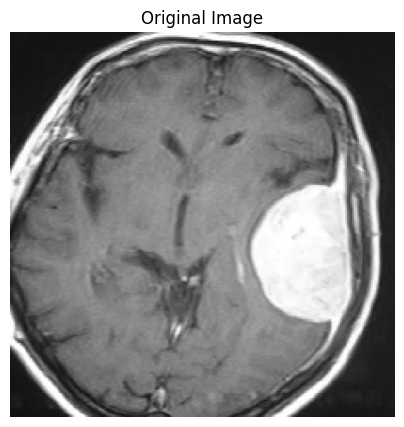

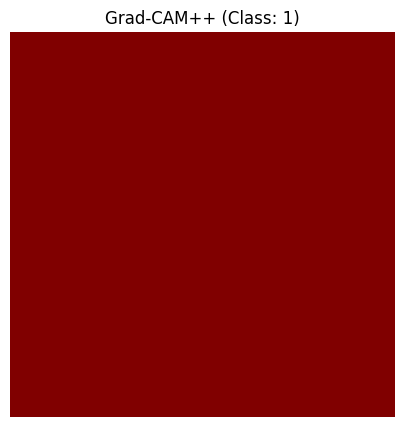

In [42]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras

def grad_cam_plus_plus(img_path, model, layer_name, img_size=(224, 224), alpha=0.3):
    # Load and preprocess image
    img = keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img_array = keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Get last convolutional layer and model output
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        class_idx = np.argmax(predictions[0])  # Get predicted class
        loss = predictions[:, class_idx]

    # Compute first-order gradients
    grads = tape.gradient(loss, conv_output)
    grads_sq = tf.square(grads)  # Second-order gradients
    grads_cube = grads_sq * grads  # Third-order gradients

    # Compute alpha values for each feature map
    sum_grads = tf.reduce_sum(conv_output, axis=(1, 2), keepdims=True)
    alpha = grads_sq / (2.0 * grads_sq + sum_grads * grads_cube + 1e-10)
    alpha = tf.where(tf.math.is_nan(alpha), tf.zeros_like(alpha), alpha)

    # Compute weighted gradients
    weighted_grads = alpha * tf.nn.relu(grads)
    weights = tf.reduce_sum(weighted_grads, axis=(0, 1, 2))

    # Compute heatmap
    conv_output = conv_output[0]
    heatmap = np.dot(conv_output, weights.numpy())
    heatmap = np.maximum(heatmap, 0)  # Apply ReLU
    heatmap /= np.max(heatmap)  # Normalize

    # Resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (img_size[1], img_size[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert original image to NumPy array and ensure float32 dtype
    original_img = np.array(img).astype(np.float32)

    # Convert alpha from tensor to float
    alpha = float(np.mean(alpha.numpy()))  # Extract single scalar float

    # Overlay heatmap on original image
    superimposed_img = cv2.addWeighted(original_img, alpha, heatmap.astype(np.float32), 1 - alpha, 0)

    # Show original image and Grad-CAM++
    plt.figure(figsize=(5, 5))
    plt.imshow(original_img.astype(np.uint8))
    plt.title("Original Image")
    plt.axis("off")

    plt.figure(figsize=(5, 5))
    plt.imshow(superimposed_img.astype(np.uint8))
    plt.title(f"Grad-CAM++ (Class: {class_idx})")
    plt.axis("off")

    plt.show()

# Run Grad-CAM++
grad_cam_plus_plus(
    img_path="/kaggle/input/brain-tumor-mris/brain_tumor_mris/Testing/meningioma/Te-me_0012.jpg",
    model=model,
    layer_name="conv2d_93"
)


In [ ]:
!pip install shap

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_3
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_3
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


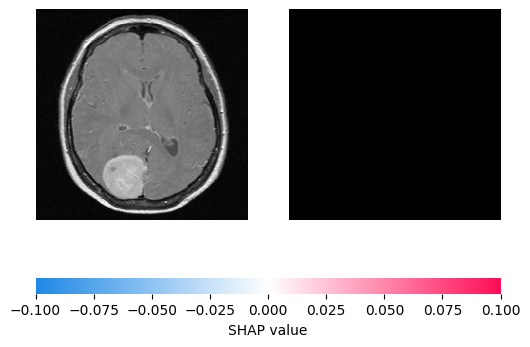

In [11]:
import shap
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array


# Function to preprocess image
def preprocess_image(img_path):
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Select an image
img_path = "/content/Te-me_0010.jpg"
img_array = preprocess_image(img_path)

# Create SHAP Explainer using Deep SHAP (for deep learning models)
explainer = shap.GradientExplainer(model, img_array)

# Compute SHAP values
shap_values = explainer.shap_values(img_array)

# Plot SHAP explanation
shap.image_plot(shap_values, img_array)


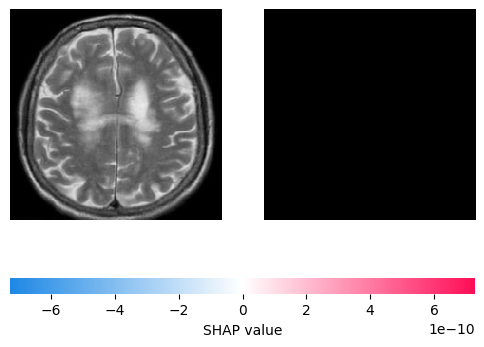

In [ ]:
import shap
import numpy as np
import tensorflow as tf

# Load SHAP background dataset (random samples from training set)
background = np.random.rand(5, 224, 224, 3)  # Small set of random images for SHAP background

# Load and preprocess the image for explanation
img_path = "/content/Te-no_0014.jpg"
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Use SHAP DeepExplainer with the final model output
explainer = shap.DeepExplainer(model, background)

# Compute SHAP values for the input image
shap_values = explainer.shap_values(img_array)

# Plot SHAP image explanation
shap.image_plot(shap_values, img_array)
